#### Visualize census tract data

In [1]:
import os
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# collect parquet files

output_file = "../census_outputs/census_tract_2020.parquet/"

parq_files = [ os.path.join(output_file, file) for file in os.listdir(output_file) if ".parquet" in file ]

parq_files.sort()

census_tract_df = dd.concat([ dd.read_parquet(file) for file in parq_files ])

In [26]:
# show first 5 rows of first partition

census_tract_df.head()

,geo_id,state_code,state_name,county,tract,tract_name,variable_code,variable_name,value,measurement,demographic_target,demographic
0,1400000US01073003600,01,Alabama,073,003600,"Census Tract 36, Jefferson County, Alabama",DP02_0001E,Estimate!!HOUSEHOLDS BY TYPE!!Total households,2019,estimate,households by type,total households
1,1400000US01073003700,01,Alabama,073,003700,"Census Tract 37, Jefferson County, Alabama",DP02_0001EA,Annotation of Estimate!!HOUSEHOLDS BY TYPE!!To...,0,annotation of estimate,households by type,total households
2,1400000US01073003802,01,Alabama,073,003802,"Census Tract 38.02, Jefferson County, Alabama",DP02_0001M,Margin of Error!!HOUSEHOLDS BY TYPE!!Total hou...,408,margin of error,households by type,total households
3,1400000US01073003803,01,Alabama,073,003803,"Census Tract 38.03, Jefferson County, Alabama",DP02_0001MA,Annotation of Margin of Error!!HOUSEHOLDS BY T...,0,annotation of margin of error,households by type,total households
4,1400000US01073003900,01,Alabama,073,003900,"Census Tract 39, Jefferson County, Alabama",DP02_0001PE,Percent!!HOUSEHOLDS BY TYPE!!Total households,2019,percent,households by type,total households


In [27]:
# show number of partitions

census_tract_df.npartitions

991

In [16]:
# Get information about DataFrame

census_tract_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, geo_id to demographic
dtypes: object(8), int64(3)

In [17]:
# show column names

census_tract_df.columns

Index(['geo_id', 'tract_name', 'state_name', 'state_code', 'county', 'tract',
       'variable_name', 'value', 'measurement', 'demographic_target',
       'demographic'],
      dtype='object')

In [18]:
# census tract count by state

state_tract_count = census_tract_df.groupby("state_name").size().reset_index().rename(columns = {0: "n"}).sort_values("n", ascending = False).compute()

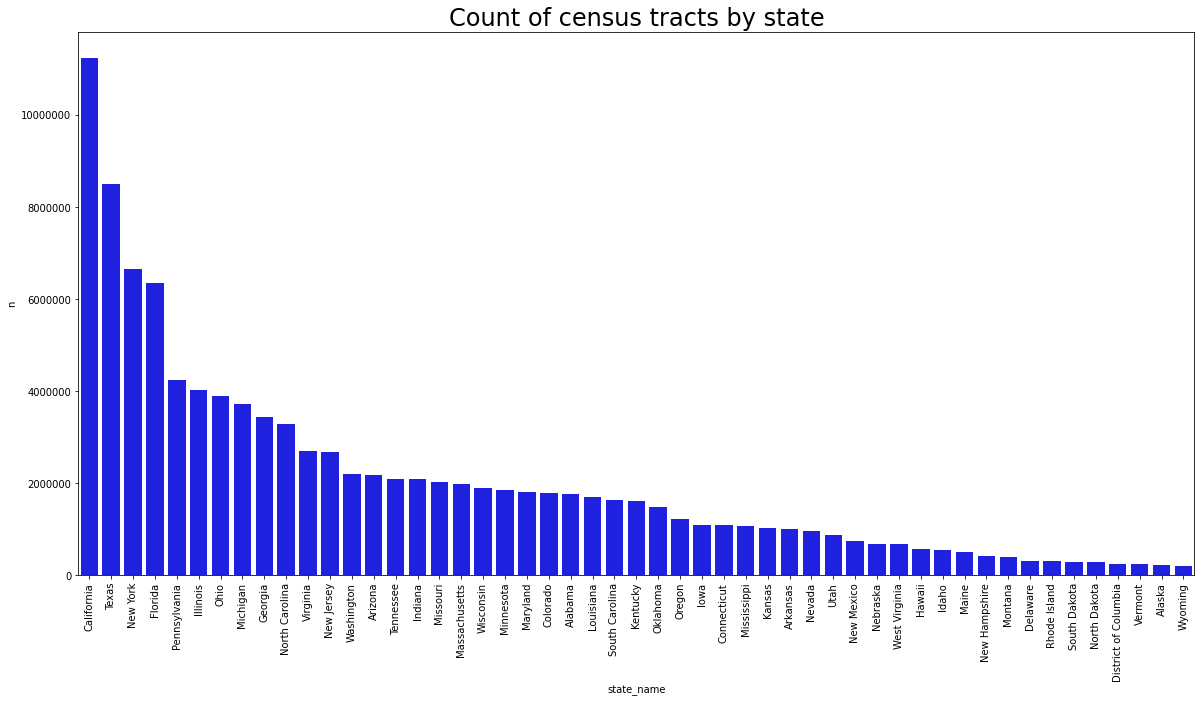

In [19]:
fig, ax = plt.subplots(figsize = (20, 10))

ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.xticks(rotation = 90)

plt.title("Count of census tracts by state", fontsize = 24)

sns.barplot(data = state_tract_count, x= "state_name", y= "n", color= "b")

plt.show()

In [20]:
# find non integer values & replace with 0

census_tract_df["value"] = dd.to_numeric(census_tract_df.value.astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)

In [21]:
# remove rows with zero or negative values

census_tract_df = census_tract_df.loc[census_tract_df["value"] > 0]

In [63]:
def census_tract_summ(group_vars, df = census_tract_df):
    df_grouped = df.groupby(group_vars).agg({"value": ["mean", "std", "count", "min", "max"]}).compute()

    df_grouped.columns = df_grouped.columns.droplevel(0)

    df_grouped = df_grouped.reset_index().sort_values(group_vars)

    return df_grouped

In [60]:
# statistical measure of each variable value by state

state_describe_df = census_tract_summ(["state_name", "variable_name"])

In [61]:
state_describe_df.head()

,state_name,variable_name,mean,std,count,min,max
380,Alabama,Estimate!!ANCESTRY!!Total population,3419.417191,1407.753256,1431,7,11493
383,Alabama,Estimate!!ANCESTRY!!Total population!!American,555.105263,447.656951,1425,1,3189
528,Alabama,Estimate!!ANCESTRY!!Total population!!Arab,40.609121,73.562056,307,1,715
543,Alabama,Estimate!!ANCESTRY!!Total population!!Czech,19.757709,30.016491,227,1,339
530,Alabama,Estimate!!ANCESTRY!!Total population!!Danish,18.421277,22.296113,235,1,204


In [83]:
# statistical measure of each variable value for all states

us_describe_df = census_tract_summ("variable_name")

# set state_name column as "USA"

us_describe_df.loc[:, "state_name"] = "USA"

In [84]:
us_describe_df.head()

,variable_name,mean,std,count,min,max,state_name
380,Estimate!!ANCESTRY!!Total population,3906.424891,1633.866307,83598,1,39373,USA
383,Estimate!!ANCESTRY!!Total population!!American,237.774322,258.725708,81439,1,8644,USA
528,Estimate!!ANCESTRY!!Total population!!Arab,57.715994,113.625668,35633,1,4745,USA
543,Estimate!!ANCESTRY!!Total population!!Czech,36.066699,55.089663,36852,1,1552,USA
530,Estimate!!ANCESTRY!!Total population!!Danish,36.026459,54.060951,34544,1,1799,USA


In [128]:
def plot_us_state_mean(variable, title, state_summ = state_describe_df, us_summ = us_describe_df):
    state_variable_summ = state_summ[state_summ["variable_name"] == variable]

    us_variable_summ = us_summ[us_summ["variable_name"] == variable]

    plot_summ_df = pd.concat([state_variable_summ, us_variable_summ]).sort_values("mean", ascending = False)

    fig, ax = plt.subplots(figsize = (20, 10))

    sns.barplot(plot_summ_df, x = "state_name", y = "mean", palette = [ "b" if x != "USA" else "r" for x in plot_summ_df["state_name"] ])

    plt.xticks(rotation=90)

    plt.title(title, fontsize = 20)

    plt.show()

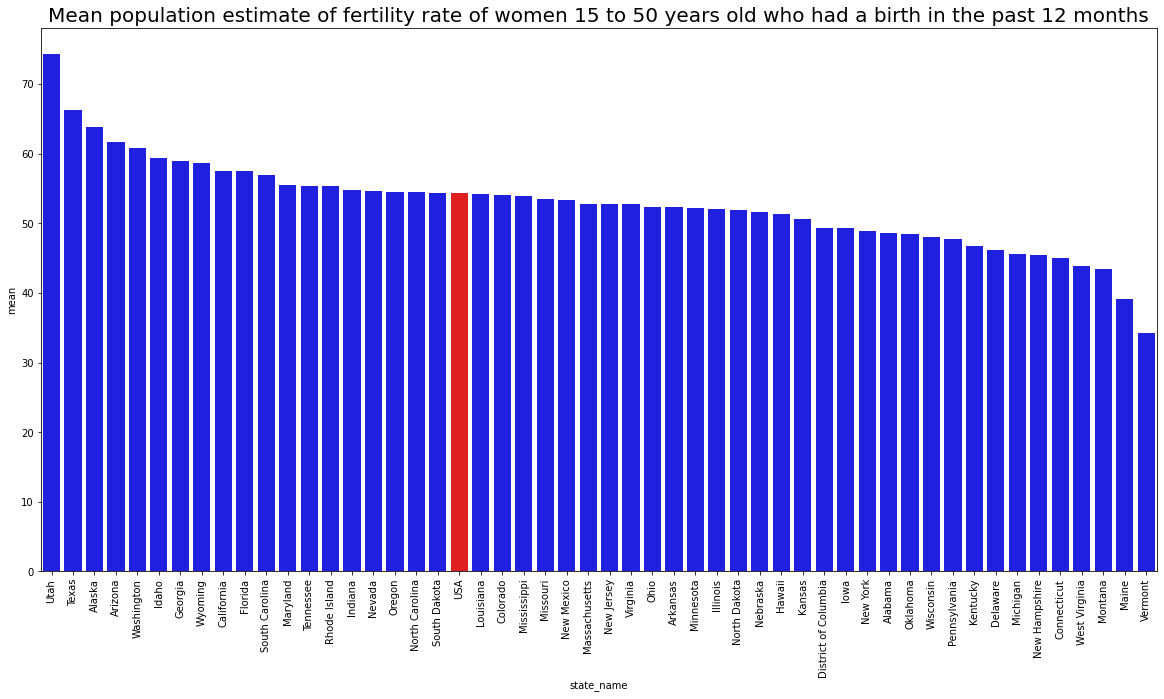

In [134]:
fertility_summ = plot_us_state_mean(
    "Estimate!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the past 12 months",
    "Mean population estimate of fertility rate of women 15 to 50 years old who had a birth in the past 12 months"
    )

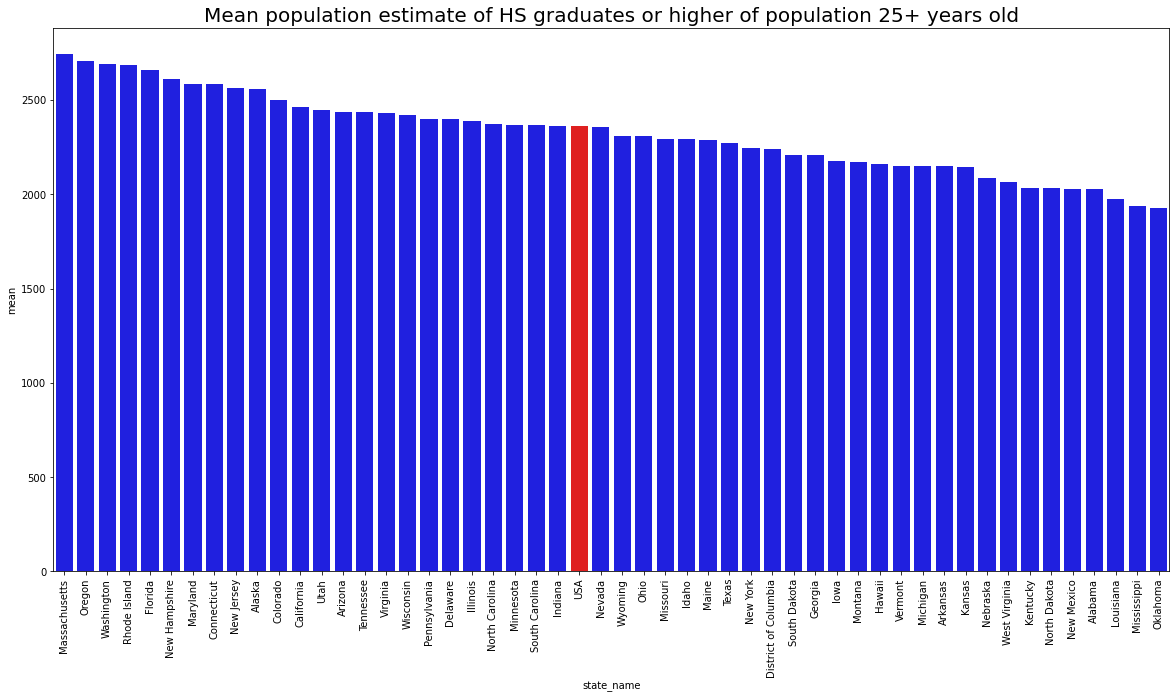

In [135]:
hs_graduate_summ = plot_us_state_mean(
    "Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate or higher",
    "Mean population estimate of HS graduates or higher of population 25+ years old"
    )

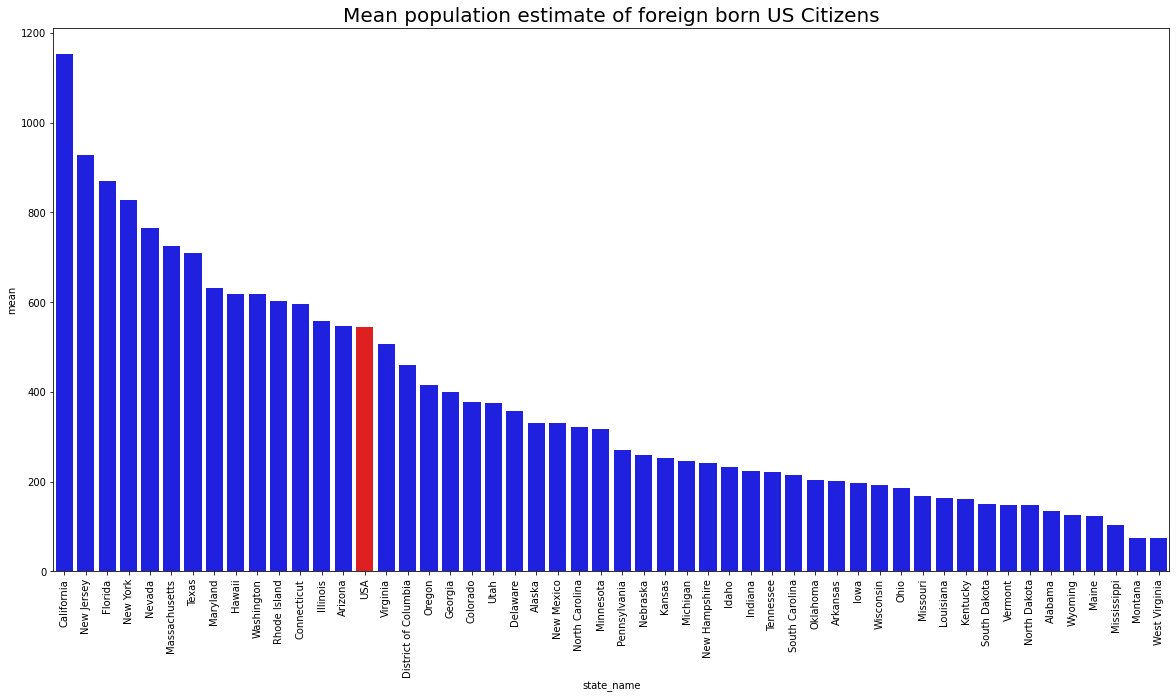

In [136]:
foreign_born_summ = plot_us_state_mean(
    "Estimate!!U.S. CITIZENSHIP STATUS!!Foreign-born population",
    "Mean population estimate of foreign born US Citizens"
    )

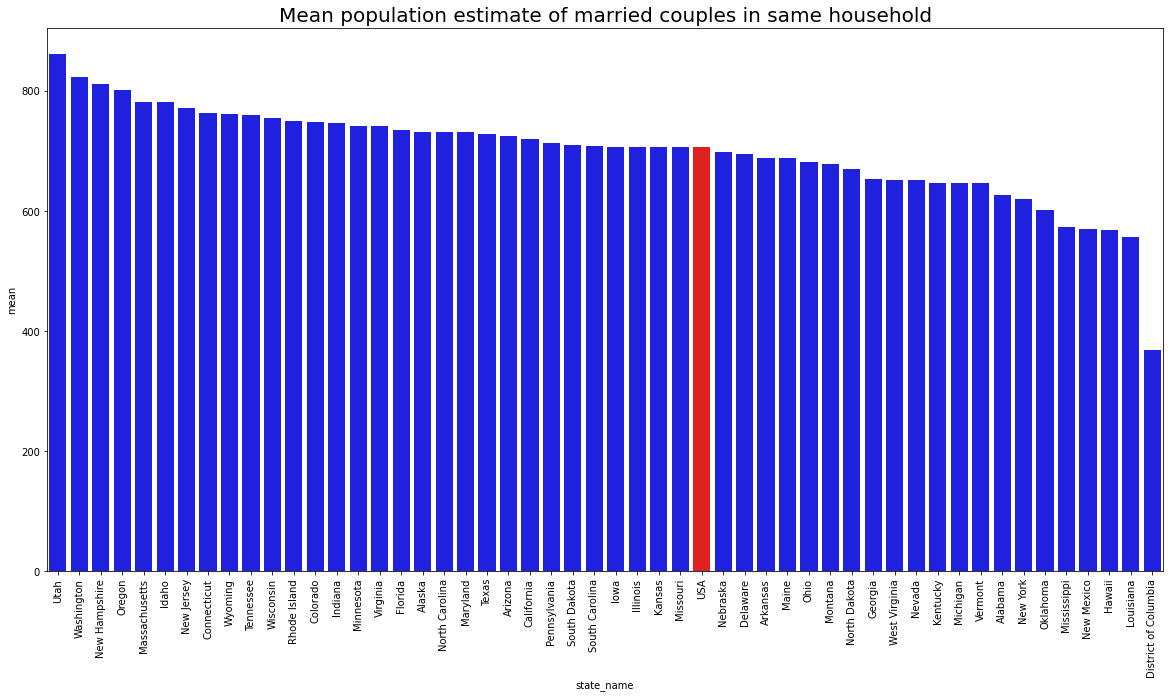

In [137]:
marriage_summ = plot_us_state_mean(
    "Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Married-couple household",
    "Mean population estimate of married couples in same household"
    )

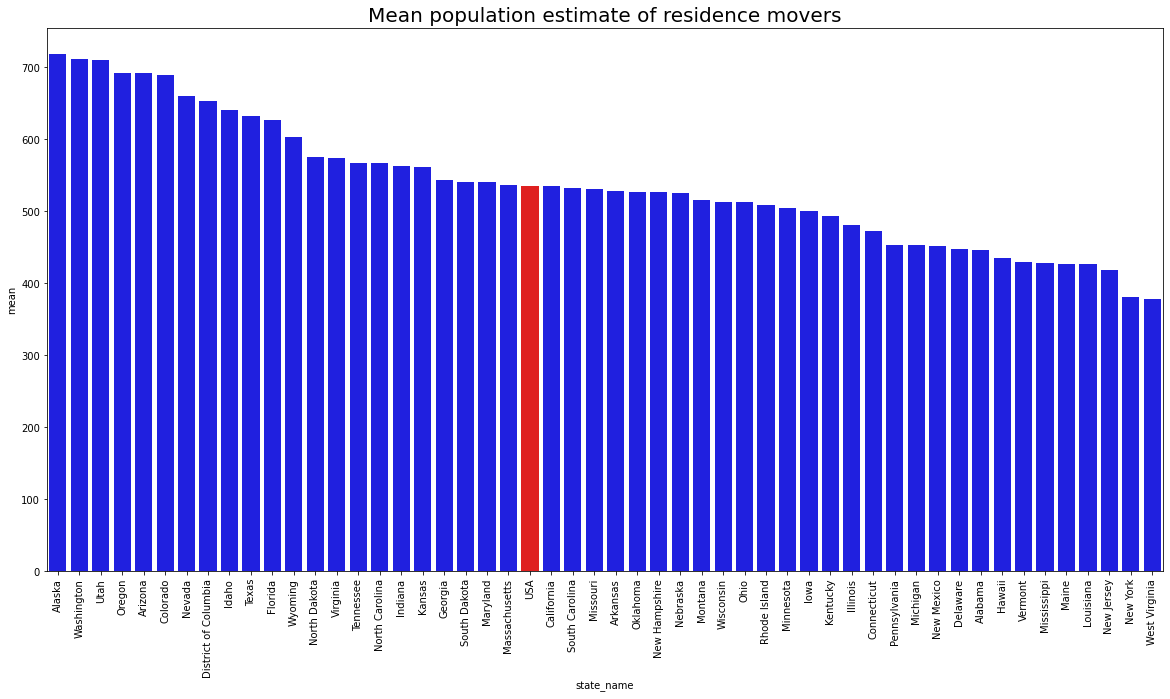

In [139]:
marriage_summ = plot_us_state_mean(
    "Estimate!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house (in the U.S. or abroad)",
    "Mean population estimate of residence movers"
    )

In [22]:
# look more into the following demographics:
#  - marital status
#  - fertility
#  - educational attainment
#  - residence 1 year ago
#  - computers and internet use
#  - u.s. citizenship status